In [10]:
import sys
import subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "milankalkenings==0.1.42"])

0

In [11]:
from typing import Tuple, List
import torch
from torchvision.datasets import MNIST
from milankalkenings.utils import make_reproducible
from milankalkenings.train_test import Module
import matplotlib.pyplot as plt
from milankalkenings.visualization import images_subplot
import random

In [12]:
make_reproducible()
monitoring_path = ""
data_path = "/data"
upscale = 2
n_obs = 1200 * upscale
n_bags = 120 * upscale
n_bags_train = 100 * upscale
n_bags_test = n_bags - n_bags_train
positive_class = 2
n_epochs = 10 #10
print_epochs = 1
lr = 0.0001
rand_max_jump = 0.01

In [13]:
class MILPooling(torch.nn.Module):
    def __init__(self, M: int, L: int):
        """
        given the embeddings of a bag, calculates
        the (weighted) mean embedding.
        each embedding is weighted by its importance for determining
        if the batch contains a positive instance or not.

        :param M: input size
        :param L: hidden size
        """
        super(MILPooling, self).__init__()
        self.w = torch.nn.Linear(in_features=L, out_features=1, bias=False)
        self.V = torch.nn.Linear(in_features=M, out_features=L, bias=False)
        self.U = torch.nn.Linear(in_features=M, out_features=L, bias=False)
        self.tanh = torch.nn.Tanh()
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        logits = torch.zeros(size=[len(embeddings)])
        for i, emb in enumerate(embeddings):
            V_e = self.tanh(self.V(emb))
            U_e = self.sigmoid(self.U(emb))
            logits_e = self.w(V_e * U_e)
            logits[i] = logits_e
        attention_scores = self.softmax(logits)
        return attention_scores @ embeddings, attention_scores


class MILClassifier(Module):
    def __init__(self, L: int):
        super(MILClassifier, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1,
                                     out_channels=20,
                                     kernel_size=5)
        self.conv2 = torch.nn.Conv2d(in_channels=20,
                                     out_channels=50,
                                     kernel_size=5)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(in_features=800, out_features=500)
        self.mil_pool = MILPooling(M=500, L=L)
        self.fc2 = torch.nn.Linear(in_features=500, out_features=1)
        self.sigmoid = torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()
        self.loss = torch.nn.BCELoss()

    def forward(self, x, y):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu(x)

        x, attention_scores = self.mil_pool(x)

        x = self.fc2(x)
        prob = self.sigmoid(x)[0]
        pred = torch.round(input=prob)
        loss = self.loss(input=prob, target=y)
        return {"loss": loss, "pred": pred, "prob": prob, "attention_scores": attention_scores}


def create_mnist_bags(data_path: str,
                      n_obs: int,
                      n_bags: int,
                      positive_class: int) -> Tuple[List[torch.Tensor], torch.Tensor]:
    """
    bags data points into bags of varying size.
    bag has label "1" if it contains at least one instance of positive_class, else "0".

    :param data_path: path to the mnist data set

    :param n_obs: number of observations used

    :param n_bags: number of bags

    :param positive_class: class that determines bag label
    :return:
    """
    mnist_train = MNIST(root=data_path + "/mnist", train=True, download=True)
    x = mnist_train.data[:n_obs]
    y = mnist_train.targets[:n_obs]

    rand = torch.rand(size=[len(y)])
    bags_x = []
    bags_y = torch.zeros(size=[n_bags])
    for bag_id in range(n_bags):
        cond = (rand < (bag_id + 1)/n_bags) & (rand > bag_id/n_bags)
        bag_x = torch.unsqueeze(x[cond].float(), dim=1)
        bags_x.append(bag_x)
        bags_y[bag_id] = torch.any(y[cond] == positive_class).float().item()
    return bags_x, bags_y


def random_change(value: float, max_amount: float):
    return random.uniform(value - value * max_amount, value + value * max_amount)

In [14]:
bags_x, bags_y = create_mnist_bags(data_path=data_path,
                                   n_bags=n_bags,
                                   n_obs=n_obs,
                                   positive_class=positive_class)
bags_x_train = bags_x[:n_bags_train]
bags_y_train = bags_y[:n_bags_train]
bags_x_test = bags_x[n_bags_train:]
bags_y_test = bags_y[n_bags_train:]

In [15]:
# training
mil_cls = MILClassifier(L=128)
mil_cls.train()
adam = torch.optim.Adam(params=mil_cls.parameters(), lr=lr)
for epoch in range(1, n_epochs):
    lr = random_change(value=lr, max_amount=lr * rand_max_jump)
    for pg in adam.param_groups:
        pg["lr"] = lr

    loss_epoch = 0
    for i in range(n_bags_train):
        bag_x = bags_x_train[i]
        bag_y = bags_y_train[i]
        loss = mil_cls(x=bag_x, y=bag_y)["loss"]
        loss_epoch += loss.item() / n_bags_train
        loss.backward()
        adam.step()
        adam.zero_grad()
    if epoch % print_epochs == 0:
        print("epoch", epoch, "loss", loss_epoch)

epoch 1 loss 1.3661538360825682
epoch 2 loss 0.26378395217486267
epoch 3 loss 0.11096717634676322
epoch 4 loss 0.05197301545130075
epoch 5 loss 0.021045900870859252
epoch 6 loss 0.020314352888988328
epoch 7 loss 0.007944288851337689
epoch 8 loss 0.0008398384274563857
epoch 9 loss 0.00046835602652052445


In [16]:
# bag level prediction accuracy on the test set:
mil_cls.eval()
preds = torch.zeros(size=[(n_bags_test)])
with torch.no_grad():
    for i in range(n_bags_test):
        bag_x = bags_x_test[i]
        bag_y = bags_y_test[i]
        preds[i] = mil_cls(x=bag_x, y=bag_y)["pred"]
print("test bags of positive class:", torch.mean(bags_y_test))
print("test acc:", torch.mean((preds == bags_y_test).float()))

test bags of positive class: tensor(0.5750)
test acc: tensor(0.9000)


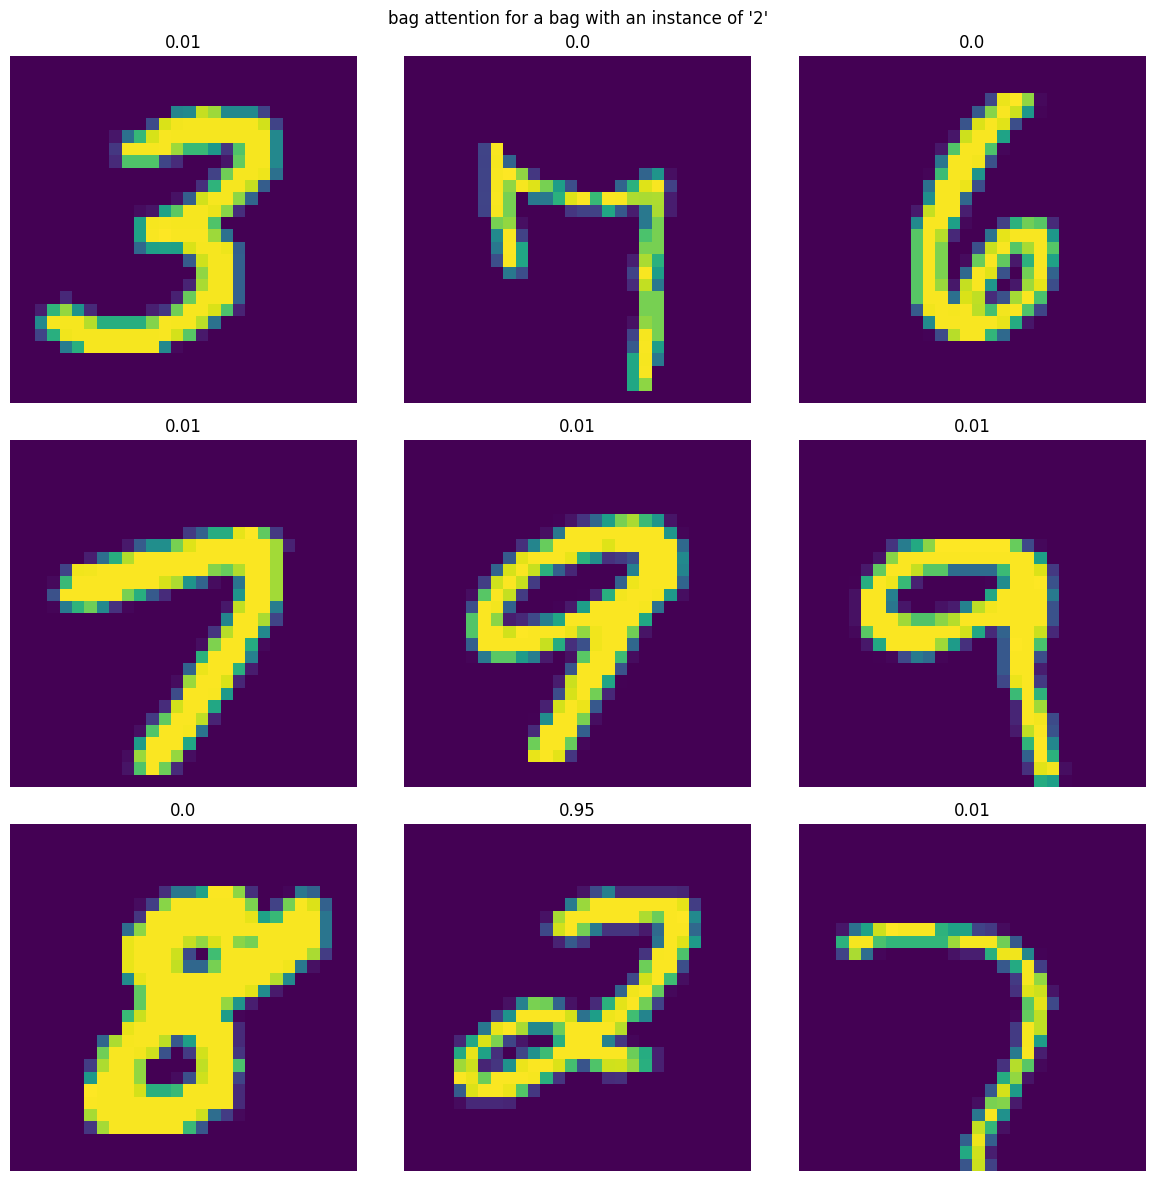

In [17]:
pos_bag_id = 5
pos_bag_x_test = bags_x_test[pos_bag_id]
pos_bag_y_test = bags_y_test[pos_bag_id]
pos_attention_scores = mil_cls(x=pos_bag_x_test, y=pos_bag_y_test)["attention_scores"]
images_subplot(images=[img for img in pos_bag_x_test],
               title="bag attention for a bag with an instance of '2'",
               subplot_titles=[str(round(a.item(), 2)) for a in pos_attention_scores],
               save_file=monitoring_path + "/pos")

- high attention to the instance of positive class

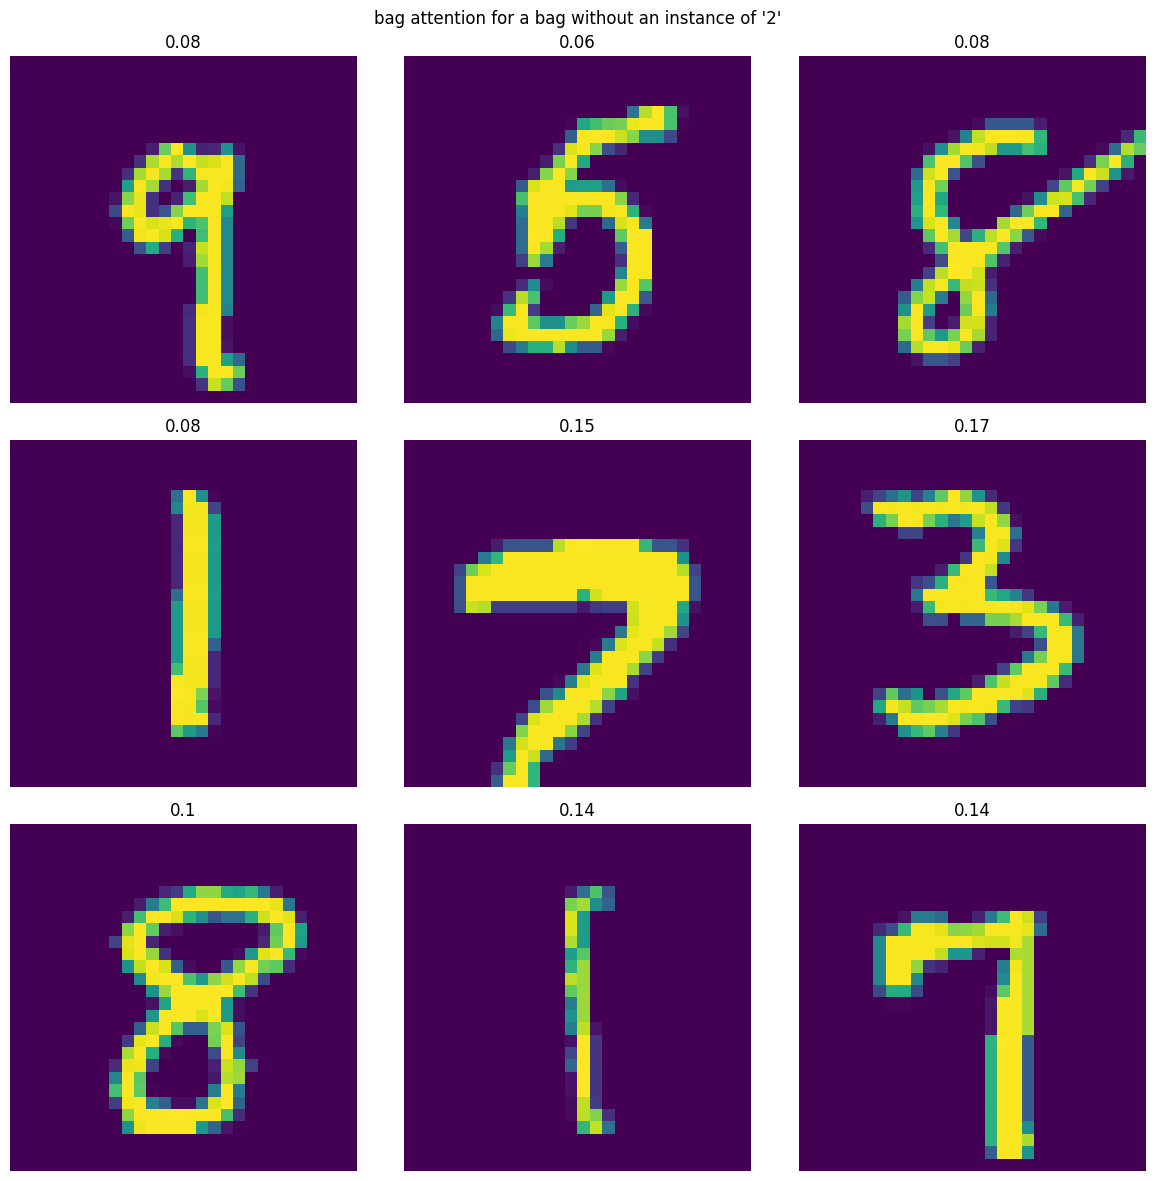

In [18]:
neg_bag_id = 1
neg_bag_x_test = bags_x_test[neg_bag_id]
neg_bag_y_test = bags_y_test[neg_bag_id]
neg_attention_scores = mil_cls(x=neg_bag_x_test, y=neg_bag_y_test)["attention_scores"]
images_subplot(images=[img for img in neg_bag_x_test],
               title="bag attention for a bag without an instance of '2'",
               subplot_titles=[str(round(a.item(), 2)) for a in neg_attention_scores],
               save_file=monitoring_path + "/neg")

- low ( close to uniform) attention to all instances, because no instance of positive class is in the bag